In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import obspy as op
import glob
import os
import fnmatch
import operator
import shutil
import matplotlib.gridspec as gridspec
from scipy import signal,stats,spatial,misc
from obspy.taup import TauPyModel
import time
from IPython import display
import matplotlib.gridspec as gridspec
from obspy.clients.fdsn import Client
from obspy.clients.iris import Client as OldIris_Client
from obspy.core.util import NamedTemporaryFile
import matplotlib.mlab as mlab
import itertools
from obspy import UTCDateTime
from matplotlib.cbook import get_sample_data
from mpl_toolkits.basemap import Basemap
from matplotlib.ticker import FormatStrFormatter

<h2 align="center">Estações Sismográficas</h2>

In [3]:
STA = ['BDCO','BPPF','BUCO','GENI','GRJU','PRDT','STSN','STSR','TRZN']

BDCO = 0, BPPF = 1 ,BUCO = 2, GENI = 3, GRJU = 4, PRDT = 5, STSN = 6, STSR = 7, TRZN = 8

In [4]:
z = 0

<h2 align="center">Recolhendo as listas com os grupos de BAZ das Funções do Receptor</h2>

In [5]:
JI_folder_all ='/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/JI_10_25_all/'+STA[z]+'/'

<h2 align="center">Transformando os arquivos das pastas para poder Plotar a Inversão Conjunta</h2>

In [6]:
RF_0_10_l = []
RF_10_l = []
RF_0_10_f = []
RF_10_f = []

os.chdir(JI_folder_all)
os.system('sac2xy 2 model.0.vs > model_0_vs.txt')
os.system('sac2xy 2 model.9.vs > model_9_vs.txt')
os.system('sac2xy 2 syn.9ur.disp > syn_9ur.txt')
os.system('sac2xy 2 urayl.sac > urayl.txt')

RF_0_10_l = op.read('rftn_lf*')
RF_10_l = op.read('syn.9lf*')
RF_0_10_f = op.read('rftn_hf*')
RF_10_f = op.read('syn.9hf*')

In [7]:
rftn_BAZ_list = glob.glob('rftn_lf*')

In [8]:
rftn_BAZ_name = [i.split('.')[0] for i in rftn_BAZ_list]

In [9]:
BAZ_name = [i.split('f')[2] for i in rftn_BAZ_name]

In [10]:
model_joint_0 = []
model_joint_9 = []

with open(JI_folder_all+'model_0_vs.txt') as inputfile:
    for line in inputfile:
        model_joint_0.append(line.strip().split())
            
with open(JI_folder_all+'model_9_vs.txt') as inputfile:
    for line in inputfile:
        model_joint_9.append(line.strip().split())
            
vs_all = []
prof_all = []

for i,j in enumerate(model_joint_9):
    vs_all.append(float(j[0]))
    prof_all.append(float(j[1]))

vs_0 = []
prof_0 = []
for i,j in enumerate(model_joint_0):
    vs_0.append(float(j[0]))
    prof_0.append(float(j[1]))

In [11]:
model_joint_0_vg_per = []
model_joint_9_vg_per = []

group_ray_periods_0 = []
group_ray_amp_0 = []

group_ray_periods_9 = []
group_ray_amp_9 = []

with open('urayl.txt') as inputfile:
    for line in inputfile:
        model_joint_0_vg_per.append(line.strip().split())
            
with open('syn_9ur.txt') as inputfile:
    for line in inputfile:
        model_joint_9_vg_per.append(line.strip().split())

for k,l in enumerate(model_joint_0_vg_per):
    group_ray_periods_0.append(float(l[0]))
    group_ray_amp_0.append(float(l[1]))

for k,l in enumerate(model_joint_9_vg_per):
    group_ray_periods_9.append(float(l[0]))
    group_ray_amp_9.append(float(l[1]))

<h2 align="center">Calculando o erro da profundidade da Bacia, MCR e Moho para cada estação</h2>

In [12]:
vel_list_BAZ = []
vel_list_BAZS = []

for root, dirs, files in os.walk('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/JI_10_25/'+STA[z]):
    for datafile in files:
        if datafile.endswith('_velocity_model_BAZ.txt'):
            vel_list_BAZ.append(os.path.join(root, datafile))
vel_list_BAZS = sorted(vel_list_BAZ)

In [13]:
model_sta_9 = [[] for x in range(len(vel_list_BAZS))]

for i,j in enumerate(vel_list_BAZS):
    with open(j) as inputfile:
        for line in inputfile:
            model_sta_9[i].append(line.strip().split())
            
vs_9 = [[] for x in range(len(vel_list_BAZS))]
prof_9 = [[] for x in range(len(vel_list_BAZS))]

for i,j in enumerate(model_sta_9):
    for k,l in enumerate(j):
        vs_9[i].append(float(l[0]))
        prof_9[i].append(float(l[1]))

In [14]:
vs_error_sub = [[] for x in range(len(vel_list_BAZS))]

for i,j in enumerate(vs_9):
    a = list(map(operator.sub, j, vs_all))
    vs_error_sub[i].append(a)

<h3 align="center">Calculando o erro da profundidade da Bacia para cada estação</h3>

In [15]:
vs_Bacia_JI = [[] for x in range(len(vel_list_BAZS))]
Bacia_JI_index = [[] for x in range(len(vel_list_BAZS))]
prof_Bacia_JI = [[] for x in range(len(vel_list_BAZS))]

for i,j in enumerate(vs_9):
    vs_Bacia_JI[i].append(min(enumerate(j[0:5]), key=lambda x: abs(x[1]-2.5))[1])
    Bacia_JI_index[i] = vs_9[i].index(vs_Bacia_JI[i][0])
    
for i,j in enumerate(Bacia_JI_index):
    prof_Bacia_JI[i].append(prof_9[i][j])

In [16]:
vs_Bacia_JI

[[2.611], [2.6313], [2.7203]]

In [17]:
vs_Bacia_JI_media = np.average(vs_Bacia_JI, axis=0)

In [18]:
Bacia_JI_index_media = min(enumerate(vs_all[0:10]), key=lambda x: abs(x[1]-vs_Bacia_JI_media[0]))[0] + 2

In [19]:
vs_error_Bacia = [[] for x in range(len(vel_list_BAZS))]

for i,j in enumerate(Bacia_JI_index):
    vs_error_Bacia[i].append(abs(vs_error_sub[i][0][j]))

In [20]:
std_vs_Bacia_media = np.std(vs_error_Bacia, axis=0, dtype=np.float64)
std_prof_Bacia_media = np.std(prof_Bacia_JI, axis=0, dtype=np.float64)

<h3 align="center">Calculando o erro da profundidade da MCR para cada estação</h3>

In [21]:
MCR_JI_index = [[] for x in range(len(vel_list_BAZS))]
vs_MCR_JI = [[] for x in range(len(vel_list_BAZS))]
prof_MCR_JI  = [[] for x in range(len(vel_list_BAZS))]

for i,j in enumerate(vs_9):
    vs_MCR_JI[i].append(max(j[13:25]))
    MCR_JI_index[i] = vs_9[i].index(vs_MCR_JI[i][0])
    
for i,j in enumerate(MCR_JI_index):
    prof_MCR_JI[i].append(prof_9[i][j])

In [22]:
vs_MCR_JI_media = np.average(vs_MCR_JI, axis=0)

In [23]:
MCR_JI_compara_vs_all = min(enumerate(vs_all[13:25]), key=lambda x: abs(x[1]-vs_MCR_JI_media[0]))[1]

In [24]:
MCR_JI_index_media = vs_all.index(MCR_JI_compara_vs_all)

In [25]:
vs_error_MCR = [[] for x in range(len(vel_list_BAZS))]

for i,j in enumerate(MCR_JI_index):
    vs_error_MCR[i].append(abs(vs_error_sub[i][0][j]))

In [26]:
std_vs_MCR_media = np.std(vs_error_MCR, axis=0, dtype=np.float64)*2
std_prof_MCR_media = np.std(prof_MCR_JI, axis=0, dtype=np.float64)*2

<h3 align="center">Calculando o erro da profundidade da Moho para cada estação</h3>

In [36]:
Moho_JI_index = [[] for x in range(len(vel_list_BAZS))]
vs_Uppper_Mantle_JI = [[] for x in range(len(vel_list_BAZS))]
vs_Moho_JI = [[] for x in range(len(vel_list_BAZS))]
prof_Moho_JI  = [[] for x in range(len(vel_list_BAZS))]
for i,j in enumerate(vs_9):
    vs_Uppper_Mantle_JI[i].append(min(enumerate(j[25:40]), key=lambda x: abs(x[1]-4.3))[1])
    Moho_JI_index[i] = vs_9[i].index(vs_Uppper_Mantle_JI[i][0])

for i,j in enumerate(Moho_JI_index):
    prof_Moho_JI[i].append(prof_9[i][j])
    vs_Moho_JI[i].append(vs_9[i][j-1])

In [37]:
vs_Moho_JI

[[4.0057], [3.9645], [4.1788]]

In [28]:
vs_Moho_JI_media = np.average(vs_Moho_JI, axis=0)
vs_Uppper_Mantle_JI_media = np.average(vs_Uppper_Mantle_JI, axis=0)

In [29]:
Moho_JI_index_media = min(enumerate(vs_all[:40]), key=lambda x: abs(x[1]-vs_Moho_JI_media[0]))[0]
Moho_JI_index_media = min(enumerate(vs_all[:40]), key=lambda x: abs(x[1]-vs_Moho_JI_media[0]))[0]

In [30]:
vs_error_Moho = [[] for x in range(len(vel_list_BAZS))]

for i,j in enumerate(Moho_JI_index):
    vs_error_Moho[i].append(abs(vs_error_sub[i][0][j]))

In [31]:
std_vs_Moho_media = np.std(vs_error_Moho, axis=0, dtype=np.float64)*2
std_prof_Moho_media = np.std(prof_Moho_JI, axis=0, dtype=np.float64)*2

<h2 align="center">Plotando os modelos de velocidade para cada Grupo de Back azimuth</h2>

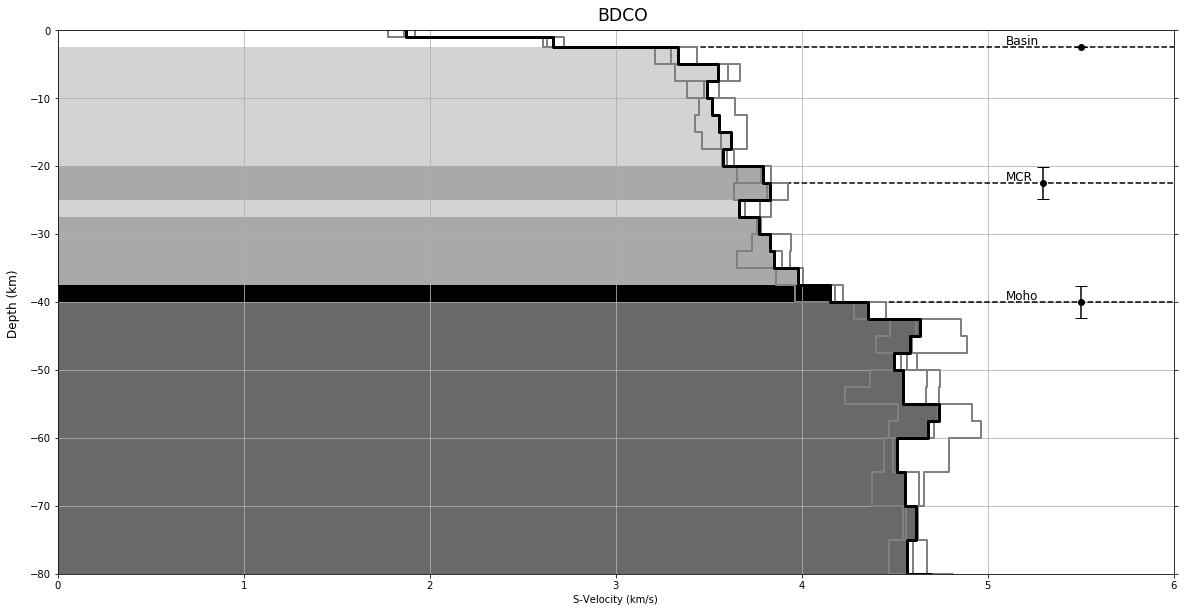

In [32]:
fig = plt.figure(figsize=(20,10),facecolor='white')
gs1 = gridspec.GridSpec(1,1,wspace=0.3, hspace=0.3)

ax1 = fig.add_subplot(gs1[0])
for i,j in enumerate(vs_9):
    ax1.step(vs_9[i],prof_9[i],'grey',lw= 2)
ax1.fill_betweenx(prof_all,0,vs_all,where=[round(i,2) <3.0 for i in vs_all],facecolor='w')
ax1.fill_betweenx(prof_all,0,vs_all,where=[round(i,2) >=3.0 and round(i,2) <3.7 for i in vs_all],facecolor='lightgray')
ax1.fill_betweenx(prof_all,0,vs_all,where=[round(i,2) >=3.7 and round(i,2) <4.0 for i in vs_all],facecolor='darkgray')
ax1.fill_betweenx(prof_all,0,vs_all,where=[round(i,2) >=4.0 and round(i,2) <4.3 for i in vs_all],facecolor='k')
ax1.fill_betweenx(prof_all,0,vs_all,where=[round(i,2) >=4.3 for i in vs_all],facecolor='dimgrey')
#ax1.step(vs_0,prof_0,'grey',lw= 3, where='post',label='Initial Model')
ax1.step(vs_all,prof_all,'k',lw= 3, where='post',label='Final Model')
plt.tick_params(top='off', bottom='on', left='on', right='on')

ax1.hlines(prof_all[Bacia_JI_index_media], 2.9, 6, colors='k', linestyles='dashed')
ax1.annotate('Basin', xy=(5.1, prof_all[Bacia_JI_index_media]+0.4), fontsize=12)
ax1.errorbar(5.5,prof_all[Bacia_JI_index_media],yerr=std_prof_Bacia_media[0],ecolor='k',capsize=6)
ax1.plot(5.5,prof_all[Bacia_JI_index_media],'ok')

ax1.hlines(prof_all[MCR_JI_index_media], 3.7, 6, colors='k', linestyles='dashed')
ax1.annotate('MCR', xy=(5.1, prof_all[MCR_JI_index_media]+0.4), fontsize=12)
ax1.errorbar(5.3,prof_all[MCR_JI_index_media],yerr=std_prof_MCR_media[0],ecolor='k',capsize=6)
ax1.plot(5.3,prof_all[MCR_JI_index_media],'ok')


ax1.hlines(prof_all[Moho_JI_index_media], 4.3, 6, colors='k', linestyles='dashed')
ax1.annotate('Moho', xy=(5.1, prof_all[Moho_JI_index_media]+0.4), fontsize=12)
ax1.plot(5.5,prof_all[Moho_JI_index_media],'ok')
ax1.errorbar(5.5,prof_all[Moho_JI_index_media],yerr=std_prof_Moho_media[0],ecolor='k',capsize=6)

ax1.set_xlim([0,6])
ax1.set_ylim([-80,-0.0])
ax1.set_xlabel('S-Velocity (km/s)')
ax1.axes.grid('on') 

fig.text(0.5, 0.9, STA[z], va='center', fontsize='xx-large')
fig.text(0.09, 0.5, 'Depth (km)', va='center', rotation='vertical',fontsize='large')
fig.savefig('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/JI_10_25_all/'+STA[z]+'/joint_inversion_model.pdf')

<h2 align="center">Plotando a inversão conjunta entre as Funções do Receptor e as Curvas de Dispersão</h2>

In [33]:
rftn_BAZ_name_org_list = np.argsort(BAZ_name)

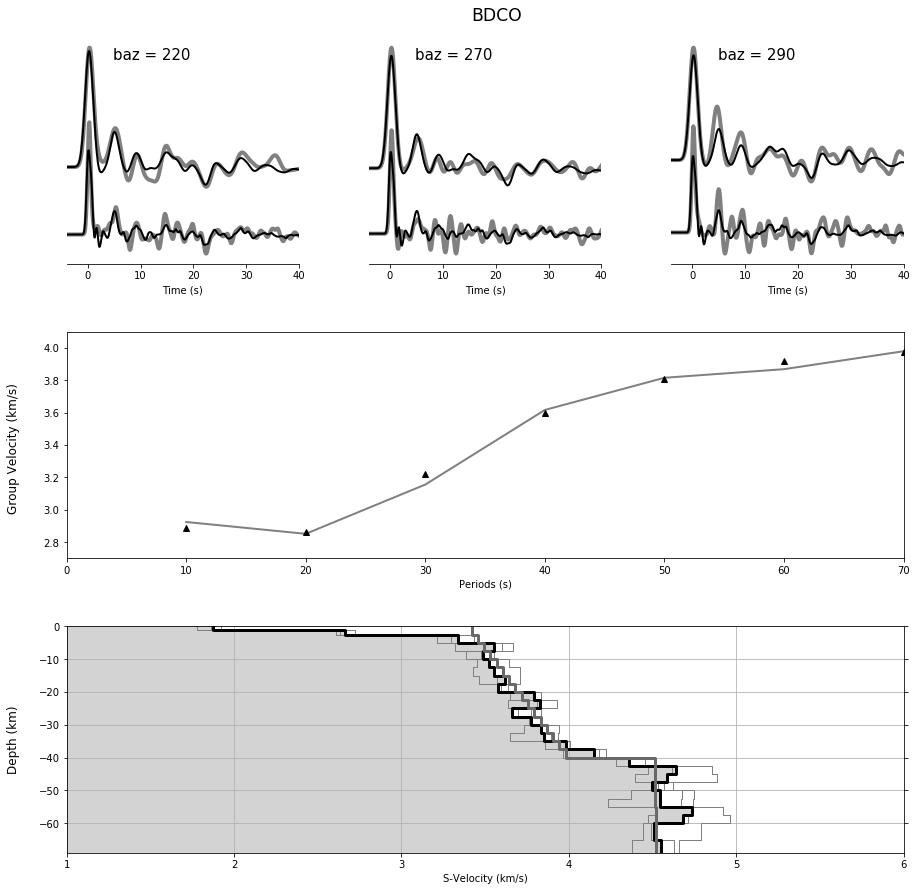

In [34]:
fig = plt.figure(figsize=(15,15),facecolor='white')
gs1 = gridspec.GridSpec(3,len(RF_0_10_f),wspace=0.3, hspace=0.3)

for j,i in enumerate(rftn_BAZ_name_org_list):
        ax4 = fig.add_subplot(gs1[0,j])
        ax4.plot(RF_0_10_f[i].times()-10,1.5*RF_0_10_f[i].data,'grey',lw=4)
        ax4.plot(RF_10_f[i].times()-10,1.5*RF_10_f[i].data,'k',lw=2)
        ax4.set_xlim(-4,40)
        ax4.set_xlabel('Time (s)')
        ax4.set_yticks([])
        ax4.spines['right'].set_visible(False)
        ax4.spines['left'].set_visible(False)
        ax4.spines['top'].set_visible(False)
 
        ax4.plot(RF_0_10_l[i].times()-10,0.5+1.5*RF_0_10_l[i].data,'grey',lw=4)
        ax4.plot(RF_10_l[i].times()-10,0.5+1.5*RF_10_l[i].data,'k',lw=2)
        ax4.set_xlim(-4,40)
        ax4.set_xlabel('Time (s)')
        ax4.set_yticks([])
        ax4.spines['right'].set_visible(False)
        ax4.spines['left'].set_visible(False)
        ax4.spines['top'].set_visible(False)
        
        ax4.text(0.2, 0.90,'baz = '+BAZ_name[i], transform=ax4.transAxes, fontsize=15)



ax5 = fig.add_subplot(gs1[1,:])
ax5.plot(group_ray_periods_0,group_ray_amp_0,'grey',lw=2,label='Observed')
ax5.plot(group_ray_periods_9,group_ray_amp_9,'^k',lw=1,label='Predicted')
ax5.set_xlim(0,70)
ax5.set_ylim(2.7,4.1)
ax5.set_xlabel('Periods (s)')
ax5.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax5.get_yaxis().set_tick_params(which='both', direction='out')
    
ax1 = fig.add_subplot(gs1[2,:])
ax1.fill_betweenx(prof_all,0,vs_all,where=[round(i,2) >=0.0 and round(i,2) <6.0 for i in vs_all],facecolor='lightgray')
plt.tick_params(top='off', bottom='on', left='on', right='on')
ax1.set_xlim([1,6])
ax1.set_ylim([-69,0])
ax1.set_xlabel('S-Velocity (km/s)')
ax1.axes.grid('on') 
for i,j in enumerate(vs_9):
    ax1.step(vs_9[i],prof_9[i],'grey',lw= 1)
ax1.step(vs_all,prof_all,'k',lw= 3, where='post',label='Final Model')
ax1.step(vs_0,prof_0,'dimgrey',lw= 3, where='post',label='Initial Model')




#    ax1.legend(loc=3)
fig.text(0.07, 0.23, 'Depth (km)', va='center', rotation='vertical',fontsize='large')
fig.text(0.07, 0.5, 'Group Velocity (km/s)', va='center', rotation='vertical',fontsize='large')
fig.text(0.5, 0.9, STA[z], va='center', fontsize='xx-large')


fig.savefig('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/JI_10_25_all/'+STA[z]+'/joint_inversion.pdf')

In [581]:
thickness = [STA[z]+"&"+str("{0:.1f}".format(abs(prof_all[Bacia_JI_index_media])))+"$\pm$"+str("{0:.2f}".format(std_prof_Bacia_media[0]))+"&"+str("{0:.1f}".format(abs(prof_all[MCR_JI_index_media])))+"$\pm$"+str("{0:.2f}".format(std_prof_MCR_media[0]))+"&"+str("{0:.1f}".format(abs(prof_all[Moho_JI_index_media])))+"$\pm$"+str("{0:.2f}".format(std_prof_Moho_media[0]))+"\\\\"]

In [582]:
velocity = [STA[z]+"&"+str("{0:.2f}".format(vs_Bacia_JI_media[0]))+"$\pm$"+str("{0:.3f}".format(std_vs_Bacia_media[0]))+"&"+str("{0:.2f}".format(vs_MCR_JI_media[0]))+"$\pm$"+str("{0:.3f}".format(std_vs_MCR_media[0]))+"&"+str("{0:.2f}".format(vs_Moho_JI_media[0]))+"$\pm$"+str("{0:.3f}".format(std_vs_Moho_media[0]))+"\\\\"]

In [583]:
np.savetxt('/home/diogo/dados_doutorado/parnaiba_basin/RF_migration/redeBP-BB/joint_inversion/JI_10_25_all/'+STA[z]+'/'+STA[z]+'_JI_estimates_error_table.txt',[thickness,velocity],fmt='%s')